# Self supervised learning

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import torchvision.transforms.functional as tf

from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, random_split
from torch.autograd import Variable
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomResizedCrop, RandomRotation, \
    RandomAffine, Resize
from matplotlib import pyplot as plt
from random import randint

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# FashionMNIST

In [4]:
class FashionMNISTDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index][0]
        target = self.targets[index][1]

        return data, target

In [5]:
root_dir = 'fashion_mnist'
batch_size=64

# Download and load the training data
train_data = FashionMNIST(root=root_dir, download=True, train=True, transform=transform)
test_data = FashionMNIST(root=root_dir, download=True, train=False, transform=transform)

In [6]:
def train_val_subset(split):
    data_set = train_data
    nbr_train_examples = int(len(data_set) * split)
    nbr_val_examples = len(data_set) - nbr_train_examples

    return random_split(data_set, [nbr_train_examples, nbr_val_examples])

In [7]:
def train_loader_classification():
    train_subset, val_subset = train_val_subset(0.8)

    train_set = FashionMNISTDataset(
        data=train_subset,
        targets=train_subset
    )
    return DataLoader(train_set, batch_size=64, shuffle=True)

In [8]:
def val_loader_classification():
    train_subset, val_subset = train_val_subset(0.8)

    val_set = FashionMNISTDataset(
        data=val_subset,
        targets=val_subset
    )
    return DataLoader(val_set, batch_size=64, shuffle=False)

In [9]:
def test_loader_classification():
    return DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
train_loader = train_loader_classification()
val_loader = val_loader_classification()
test_loader = test_loader_classification()

print("Train loader classification")
for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
print("\nVal loader classification")    
for xs, ys in val_loader:
    print(xs.size(), ys.size())
    print(ys)
    break

print("\nTest loader classification")
for xs, ys in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    break        

Train loader classification
torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([0, 8, 8, 3, 2, 3, 7, 1, 1, 1, 1, 9, 3, 3, 5, 5, 0, 0, 5, 2, 9, 2, 9, 6,
        6, 8, 2, 4, 2, 6, 1, 8, 1, 2, 9, 4, 2, 0, 1, 2, 8, 3, 9, 2, 7, 8, 4, 5,
        6, 8, 6, 4, 2, 1, 6, 0, 9, 3, 9, 8, 8, 6, 6, 4])

Val loader classification
torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([8, 4, 2, 6, 3, 8, 1, 7, 0, 2, 2, 5, 5, 2, 2, 0, 2, 6, 2, 3, 7, 3, 7, 0,
        9, 8, 5, 4, 0, 9, 0, 5, 6, 3, 7, 5, 1, 0, 1, 9, 9, 3, 7, 6, 9, 1, 3, 1,
        0, 8, 9, 4, 3, 5, 4, 5, 7, 0, 1, 5, 2, 7, 9, 2])

Test loader classification
torch.Size([64, 1, 28, 28]) torch.Size([64])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


## Rotation

In [11]:
# Rotate given images by given angle
def rotate(image, angle):
    image = tf.to_pil_image(image)
    image = tf.resize(image, 32, interpolation=2)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    image = tf.normalize(image, (0.5, ), (0.5, ))

    return image

In [12]:
class FashionMNISTRotation(Dataset):

    def __init__(self, data, target, angle):
        self.data = data
        self.target = target
        self.angle = angle

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = rotate(self.data[index][0], self.angle)
        target = None

        if self.angle == 0:
            target = 0
        if self.angle == 90:
            target = 1
        if self.angle == 180:
            target = 2
        if self.angle == 270:
            target = 3

        return data, target

In [13]:
def train_data_rotation():
    train_sub, _ = train_val_subset(0.8)

    train_set_0 = FashionMNISTRotation(
        data=train_sub,
        target=train_sub,
        angle=0
    )

    train_set_90 = FashionMNISTRotation(
        data=train_sub,
        target=train_sub,
        angle=90
    )

    train_set_180 = FashionMNISTRotation(
        data=train_sub,
        target=train_sub,
        angle=180
    )

    train_set_270 = FashionMNISTRotation(
        data=train_sub,
        target=train_sub,
        angle=270
    )

    train_data_rotation = ConcatDataset([train_set_0, train_set_90, train_set_180, train_set_270])
    print('Size of train set for rotation: {}'.format(len(train_data_rotation)))
    return train_data_rotation

In [14]:
def train_loader_rotation():
    return DataLoader(train_data_rotation(), batch_size=batch_size, shuffle=True, num_workers=1)

In [15]:
def val_data_rotation():
    _, val_subset = train_val_subset(0.8)

    val_set_0 = FashionMNISTRotation(
        data=val_subset,
        target=val_subset,
        angle=0
    )

    val_set_90 = FashionMNISTRotation(
        data=val_subset,
        target=val_subset,
        angle=90
    )

    val_set_180 = FashionMNISTRotation(
        data=val_subset,
        target=val_subset,
        angle=180
    )

    val_set_270 = FashionMNISTRotation(
        data=val_subset,
        target=val_subset,
        angle=270
    )

    val_data_rotation = ConcatDataset([val_set_0, val_set_90, val_set_180, val_set_270])
    print('Size of validation set for rotation: {}'.format(len(val_data_rotation)))
    return val_data_rotation

In [16]:
def val_loader_rotation():
    return DataLoader(val_data_rotation(), batch_size=batch_size, shuffle=False, num_workers=1)

In [17]:
def test_data_rotation():
    data_set = test_data

    test_set_0 = FashionMNISTRotation(
        data=data_set,
        target=data_set,
        angle=0
    )

    test_set_90 = FashionMNISTRotation(
        data=data_set,
        target=data_set,
        angle=90
    )

    test_set_180 = FashionMNISTRotation(
        data=data_set,
        target=data_set,
        angle=180
    )

    test_set_270 = FashionMNISTRotation(
        data=data_set,
        target=data_set,
        angle=270
    )

    test_data_rotation = ConcatDataset([test_set_0, test_set_90, test_set_180, test_set_270])
    print('Size of train set for rotation: {}'.format(len(test_data_rotation)))
    return test_data_rotation

In [18]:
def test_loader_rotation():
    return DataLoader(test_data_rotation(), batch_size=batch_size, shuffle=False, num_workers=1)

In [19]:
train_loader = train_loader_rotation()
val_loader = val_loader_rotation()
test_loader = test_loader_rotation()

for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in val_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    break       

Size of train set for rotation: 192000
Size of validation set for rotation: 48000
Size of train set for rotation: 40000
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([3, 1, 3, 0, 0, 1, 3, 1, 1, 1, 0, 3, 2, 2, 3, 2, 0, 3, 3, 3, 2, 3, 1, 3,
        3, 3, 1, 2, 2, 3, 2, 2, 0, 3, 3, 1, 0, 0, 0, 3, 3, 3, 1, 2, 0, 0, 3, 3,
        2, 0, 0, 0, 3, 1, 1, 2, 1, 3, 3, 3, 0, 0, 1, 2])
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Size of train set for rotation: 192000


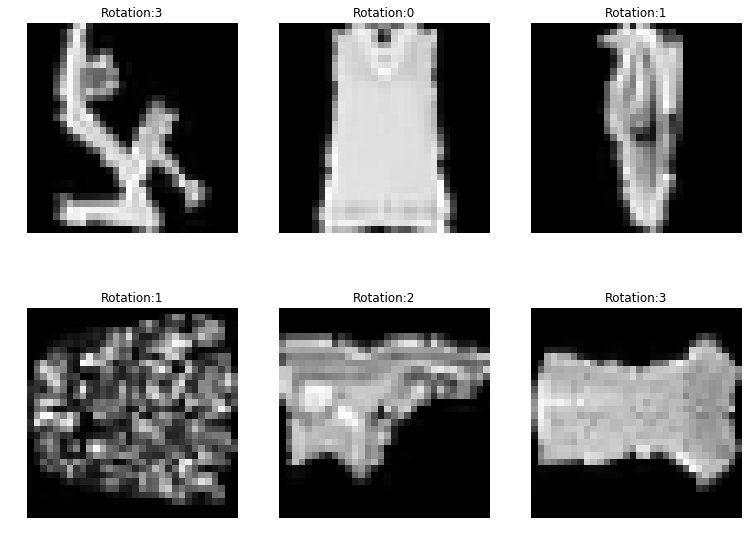

In [20]:
from matplotlib import pyplot as plt
from random import randint
dataset = train_data_rotation()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Rotation:' + str(label))
    axes[i].axis('off')  

Size of validation set for rotation: 48000


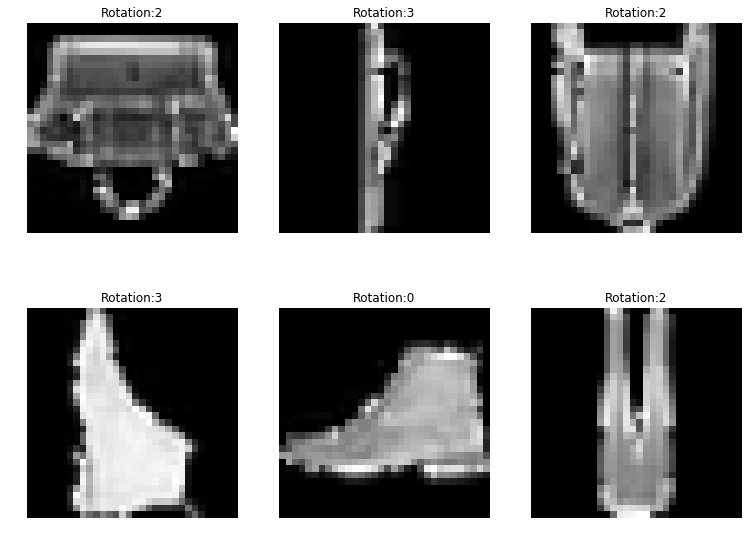

In [21]:
from matplotlib import pyplot as plt
from random import randint
dataset = val_data_rotation()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Rotation:' + str(label))
    axes[i].axis('off')  

Size of train set for rotation: 40000


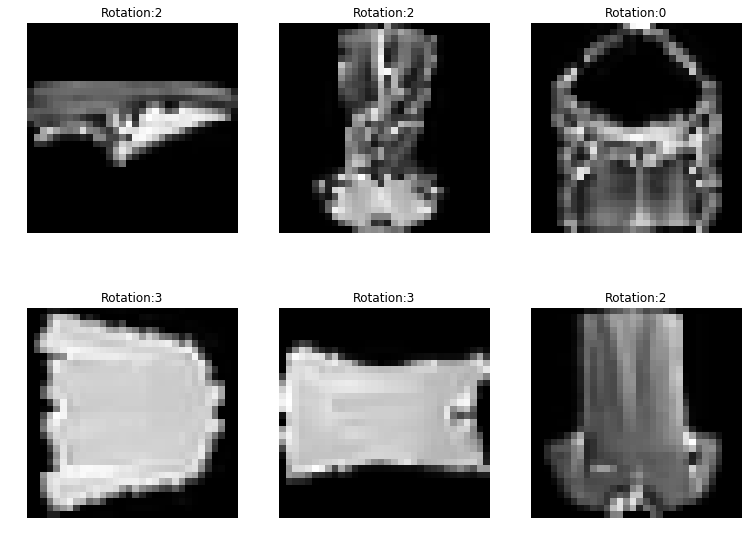

In [22]:
from matplotlib import pyplot as plt
from random import randint
dataset = test_data_rotation()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Rotation:' + str(label))
    axes[i].axis('off')  

## Exemplar CNN

In [23]:
def horizontal_flip(image):
    transform = Compose([
        RandomHorizontalFlip(p=1.0),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_crop(image):
    transform = Compose([
        RandomCrop((20, 20)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def color_jitter(image):
    transform = Compose([
        ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.02),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_resized_crop(image):
    transform = Compose([
        RandomResizedCrop(50, scale=(0.2, 1.0), ratio=(0.75, 1.333)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_rotation(image):
    transform = Compose([
        RandomRotation(45),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_affine_transformation(image):
    transform = Compose([
        RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.3), shear=10),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img

In [24]:
def random_transform(image):
    transform = ToPILImage()
    img = transform(image)

    transformation = randint(0, 5)

    if transformation == 0:
        return horizontal_flip(img)
    if transformation == 1:
        return random_crop(img)
    if transformation == 2:
        return color_jitter(img)
    if transformation == 3:
        return random_resized_crop(img)
    if transformation == 4:
        return random_rotation(img)
    if transformation == 5:
        return random_affine_transformation(img)

In [25]:
class ExemplarCNN(Dataset):

    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = random_transform(self.data[index][0])
        target = index

        return data, target

In [26]:
def train_data_exemplar_cnn():
    train_subset, val_subset = train_val_subset(0.5)

    train_set_exemplar_cnn = ExemplarCNN(
        data=train_subset,
        target=train_subset,
    )

    print('Size of train set for exemplar cnn: {}'.format(len(train_set_exemplar_cnn)))
    return train_set_exemplar_cnn

In [27]:
def val_data_exemplar_cnn():
    train_subset, val_subset = train_val_subset(0.5)

    val_set_exemplar_cnn = ExemplarCNN(
        data=val_subset,
        target=val_subset,
    )

    print('Size of validation set for exemplar cnn: {}'.format(len(val_set_exemplar_cnn)))
    return val_set_exemplar_cnn

In [28]:
def test_data_exemplar_cnn():
    data = test_data

    test_set_exemplar_cnn = ExemplarCNN(
        data=data,
        target=data,
    )

    print('Size of test set for exemplar cnn: {}'.format(len(test_set_exemplar_cnn)))
    return test_set_exemplar_cnn

In [29]:
def train_loader_exemplar_cnn():
    return DataLoader(train_data_exemplar_cnn(), batch_size=64, shuffle=True)

In [30]:
def val_loader_exemplar_cnn():
    return DataLoader(val_data_exemplar_cnn(), batch_size=64, shuffle=False)

In [31]:
def test_loader_exemplar_cnn():
    return DataLoader(test_data_exemplar_cnn(), batch_size=64, shuffle=False)

In [32]:
train_loader = train_loader_exemplar_cnn()
val_loader = val_loader_exemplar_cnn()
test_loader = test_loader_exemplar_cnn()

for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in val_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    break       

Size of train set for exemplar cnn: 30000
Size of validation set for exemplar cnn: 30000
Size of test set for exemplar cnn: 10000
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([ 4382,  2566, 15844,  3239, 14895, 20636, 25751, 25202,  5747, 29028,
         3824, 16797,  5957,  1684, 22350, 25136, 29594, 27660, 27391, 21681,
        13996, 21459,  5123,   125, 15697,  3139,  7528,  1307, 23716, 26713,
        14801,  4758,  1388, 20357,  8679, 20084, 11935,  2754,  2197, 21488,
        27589, 12155,  4081,  5908,  1543,  9749, 25714,  6063, 10481, 14831,
        14254, 22570,  8759, 14979,  6813,  3115, 18030, 24116, 10716,  3028,
        20103,  8877,  4224,  6608])
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60,

Size of train set for exemplar cnn: 30000


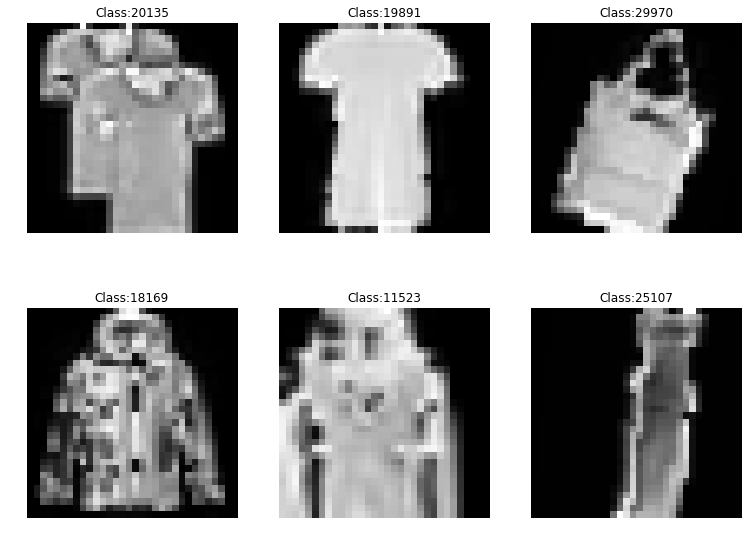

In [33]:
from matplotlib import pyplot as plt
from random import randint
dataset = train_data_exemplar_cnn()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

Size of validation set for exemplar cnn: 30000


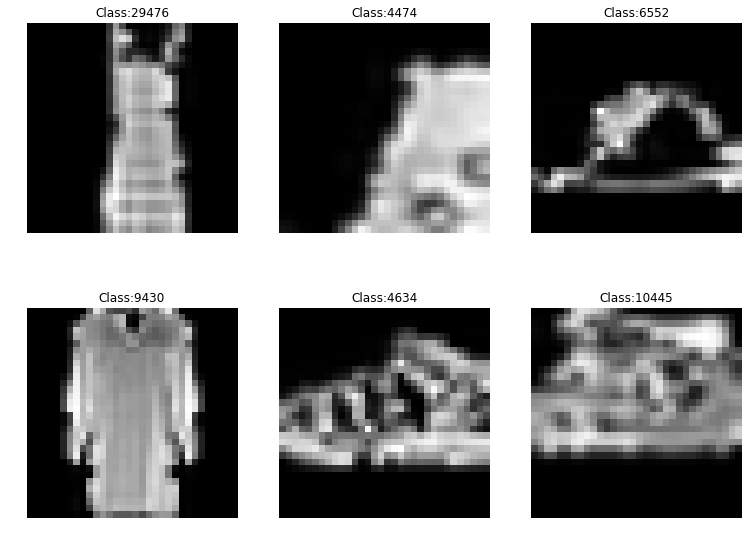

In [34]:
from matplotlib import pyplot as plt
from random import randint
dataset = val_data_exemplar_cnn()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

Size of test set for exemplar cnn: 10000


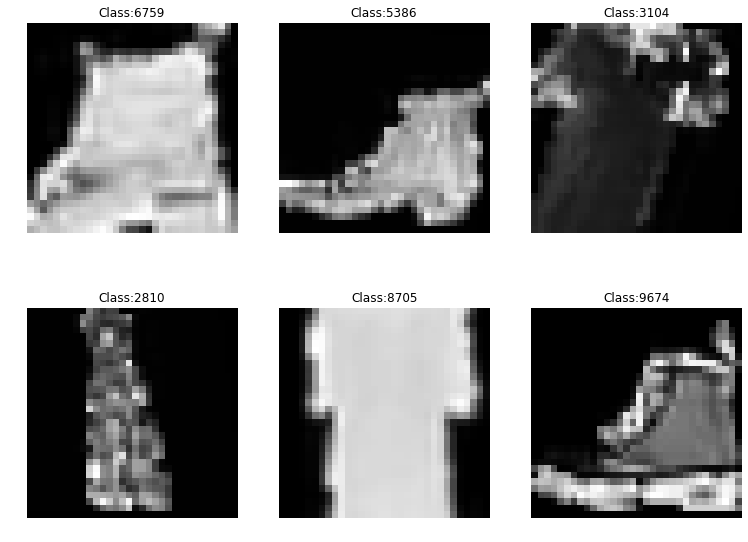

In [35]:
from matplotlib import pyplot as plt
from random import randint
dataset = test_data_exemplar_cnn()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

## Exemplar CNN augmented

In [36]:
def random_transform(image, transformation):
    transform = ToPILImage()
    img = transform(image)

    if transformation == 0:
        return horizontal_flip(img)
    if transformation == 1:
        return random_crop(img)
    if transformation == 2:
        return color_jitter(img)
    if transformation == 3:
        return random_resized_crop(img)
    if transformation == 4:
        return random_rotation(img)
    if transformation == 5:
        return random_affine_transformation(img)

In [37]:
class ExemplarCNNVariant2(Dataset):

    def __init__(self, data, target, transformation):
        self.data = data
        self.target = target
        self.transformation = transformation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = random_transform(self.data[index][0], self.transformation)
        target = index

        return data, target, self.transformation

In [49]:
def train_data_exemplar_cnn_augmented():
    train_sub, _ = train_val_subset(0.5)

    train_set_horizontal_flip = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=0
    )

    train_set_random_crop = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=1
    )

    train_set_color_jitter = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=2
    )

    train_set_random_resized_crop = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=3
    )

    train_set_random_rotation = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=4
    )

    train_set_random_affine_transformation = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=5
    )

    train_data_set_exemplar_cnn_augmented = ConcatDataset([train_set_horizontal_flip, train_set_random_crop,
                                                           train_set_color_jitter, train_set_random_resized_crop,
                                                           train_set_random_rotation,
                                                           train_set_random_affine_transformation])
    print('Size of train set for exemplar cnn augmented: {}'.format(len(train_data_set_exemplar_cnn_augmented)))
    return train_data_set_exemplar_cnn_augmented

In [50]:
def val_data_exemplar_cnn_augmented():
    train_sub, val_sub = train_val_subset(0.5)

    val_set_horizontal_flip = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=0
    )

    val_set_random_crop = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=1
    )

    val_set_color_jitter = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=2
    )

    val_set_random_resized_crop = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=3
    )

    val_set_random_rotation = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=4
    )

    val_set_random_affine_transformation = ExemplarCNNVariant2(
        data=train_sub,
        target=train_sub,
        transformation=5
    )

    val_data_set_exemplar_cnn_augmented = ConcatDataset([val_set_horizontal_flip, val_set_random_crop,
                                                         val_set_color_jitter, val_set_random_resized_crop,
                                                         val_set_random_rotation,
                                                         val_set_random_affine_transformation])
    print('Size of train set for exemplar cnn augmented: {}'.format(len(val_data_set_exemplar_cnn_augmented)))
    return val_data_set_exemplar_cnn_augmented

In [51]:
def test_data_exemplar_cnn_augmented():
    data_set = test_data

    test_set_horizontal_flip = ExemplarCNNVariant2(
        data=data_set,
        target=data_set,
        transformation=0
    )

    test_set_random_crop = ExemplarCNNVariant2(
        data=data_set,
        target=data_set,
        transformation=1
    )

    test_set_color_jitter = ExemplarCNNVariant2(
        data=data_set,
        target=data_set,
        transformation=2
    )

    test_set_random_resized_crop = ExemplarCNNVariant2(
        data=data_set,
        target=data_set,
        transformation=3
    )

    test_set_random_rotation = ExemplarCNNVariant2(
        data=data_set,
        target=data_set,
        transformation=4
    )

    test_set_random_affine_transformation = ExemplarCNNVariant2(
        data=data_set,
        target=data_set,
        transformation=5
    )

    test_data_set_exemplar_cnn_augmented = ConcatDataset([test_set_horizontal_flip, test_set_random_crop,
                                                          test_set_color_jitter, test_set_random_resized_crop,
                                                          test_set_random_rotation,
                                                          test_set_random_affine_transformation])
    print('Size of train set for exemplar cnn augmented: {}'.format(len(test_data_set_exemplar_cnn_augmented)))
    return test_data_set_exemplar_cnn_augmented

In [52]:
def train_loader_exemplar_cnn_augmented():
    return DataLoader(train_data_exemplar_cnn_augmented(), batch_size=batch_size, shuffle=True, num_workers=1)

In [53]:
def val_loader_exemplar_cnn_augmented():
    return DataLoader(val_data_exemplar_cnn_augmented(), batch_size=batch_size, shuffle=False, num_workers=1)

In [54]:
def test_loader_exemplar_cnn_augmented():
    return DataLoader(test_data_exemplar_cnn_augmented(), batch_size=batch_size, shuffle=False, num_workers=1)

In [56]:
train_loader = train_loader_exemplar_cnn_augmented()
val_loader = val_loader_exemplar_cnn_augmented()
test_loader = test_loader_exemplar_cnn_augmented()

for xs, ys, zs in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    print(zs)
    break    
    
for xs, ys, zs in val_loader:
    print(xs.size(), ys.size())
    print(ys)
    print(zs)
    break    
    
for xs, ys, zs in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    print(zs)
    break    

Size of train set for exemplar cnn augmented: 180000
Size of train set for exemplar cnn augmented: 180000
Size of train set for exemplar cnn augmented: 60000
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([15512,  4867, 14357, 19656,  1979,  3050,  2368, 11867,  6031, 23766,
        11917,  2056, 10729, 16116, 13712, 19039,  6299, 23946, 18275, 29864,
        17680,  8219, 13230, 27382, 20000, 19392, 14839,  3897,  2060, 28389,
        10418, 23036, 21125,  4849,  3888,  1866,  7279, 19254, 28631, 14328,
           99,   650,  8956, 15024, 14326, 26344,  2288, 25688, 16221,  1869,
        20755, 25306,  8364, 20824, 18442, 10461, 21026, 10585,  8832, 21628,
        12900, 12985, 18862, 24354])
tensor([4, 5, 4, 5, 3, 3, 4, 3, 2, 5, 5, 3, 5, 5, 4, 2, 2, 4, 2, 5, 5, 2, 3, 3,
        2, 4, 1, 4, 4, 4, 2, 5, 1, 4, 2, 4, 0, 3, 2, 1, 5, 0, 3, 4, 4, 2, 4, 5,
        3, 0, 1, 2, 5, 0, 0, 5, 5, 5, 3, 5, 3, 1, 2, 4])
torch.Size([64, 1, 32, 32]) torch.Size([64])
tensor([ 0,  1,  2,  3,  4,  5

Size of train set for exemplar cnn augmented: 180000


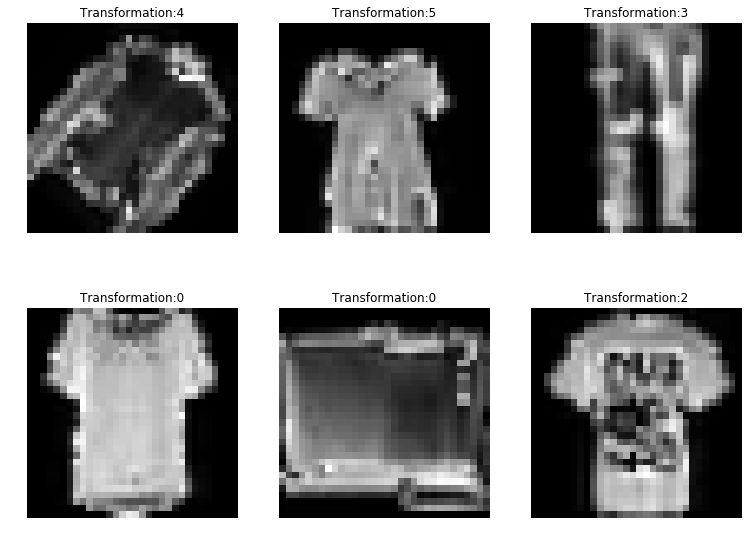

In [57]:
from matplotlib import pyplot as plt
from random import randint
dataset = train_data_exemplar_cnn_augmented()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label, transformation = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Transformation:' + str(transformation))
    axes[i].axis('off')  

Size of train set for exemplar cnn augmented: 180000


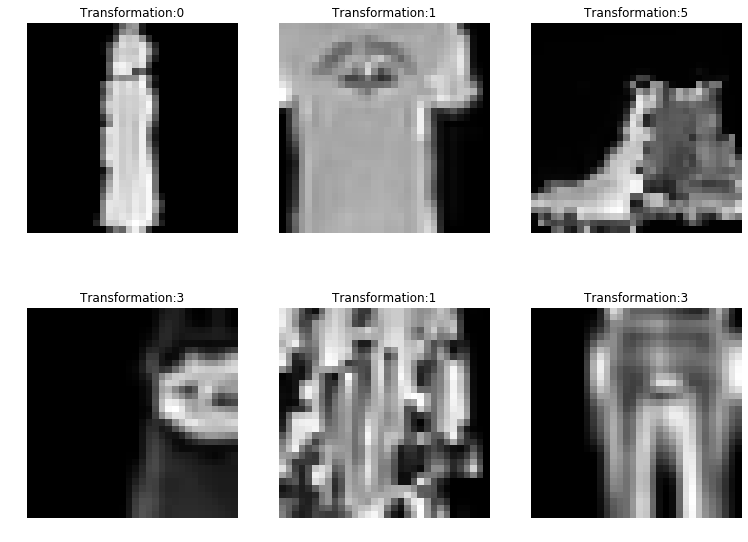

In [58]:
from matplotlib import pyplot as plt
from random import randint
dataset = val_data_exemplar_cnn_augmented()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label, transformation = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Transformation:' + str(transformation))
    axes[i].axis('off')  

Size of train set for exemplar cnn augmented: 60000


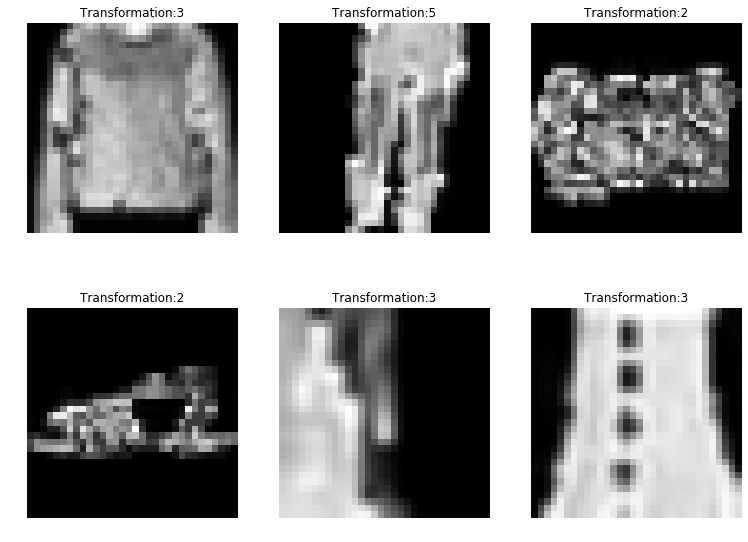

In [59]:
from matplotlib import pyplot as plt
from random import randint
dataset = test_data_exemplar_cnn_augmented()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label, transformation = dataset[index]
    axes[i].imshow(image[0].view(32, 32), cmap='gray')
    axes[i].set_title('Transformation:' + str(transformation))
    axes[i].axis('off')  

## DeepFashion

In [60]:
from torch.utils.data import Dataset

class DeepFashionDataset(Dataset):

    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.data[index][0]
        target = self.target[index]

        return datapoint, target

In [61]:
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import pandas as pd

root_dir = 'img/'
target_size = (256, 256)

def load_images():
    transforms = Compose([
        Resize(target_size),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    return ImageFolder(root_dir, transform=transforms)

In [62]:
def load_list_category_img():
    list_category_img = pd.read_csv('list_category_img.txt', sep="\t", header=0)
    list_category_img.columns = ["image_name", "category_label"]
    return list_category_img

In [63]:
def load_list_category_cloth():
    list_category_cloth = pd.read_csv('list_category_cloth.txt', sep="\t", header=0)
    list_category_cloth.columns = ["category_name", "category_type"]
    return list_category_cloth

In [64]:
def load_list_eval_partition():
    list_eval_partition = pd.read_csv('list_eval_partition.txt', sep="\t", header=0)
    list_eval_partition.columns = ["image_name", "evaluation_status"]
    return list_eval_partition

In [65]:
def train_data():
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    train_indices = partition[partition.evaluation_status == 'train'].index
    train_images = Subset(images, train_indices)
    train_labels = labels.category_label[train_indices].values

    return DeepFashionDataset(train_images, train_labels)

In [66]:
def val_data():
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    val_indices = partition[partition.evaluation_status == 'val'].index
    val_images = Subset(images, val_indices)
    val_labels = labels.category_label[val_indices].values
    return DeepFashionDataset(val_images, val_labels)

In [67]:
def test_data():
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    test_indices = partition[partition.evaluation_status == 'test'].index
    test_images = Subset(images, test_indices)
    test_labels = labels.category_label[test_indices].values
    return DeepFashionDataset(test_images, test_labels)

In [68]:
def train_loader():
    return DataLoader(train_data(), batch_size=64, shuffle=True)

In [69]:
def val_loader():
    return DataLoader(val_data(), batch_size=64, shuffle=False)

In [70]:
def test_loader():
    return DataLoader(test_data(), batch_size=64, shuffle=False)

In [71]:
train_loader_deep_fashion = train_loader()
val_loader_deep_fashion = val_loader()
test_loader_deep_fashion = test_loader()

for xs, ys in train_loader_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in val_loader_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in test_loader_deep_fashion:
    print(xs.size(), ys.size())
    print(ys)
    break      

torch.Size([64, 3, 256, 256]) torch.Size([64])
tensor([41, 33, 16, 32, 19, 32, 18, 41, 42, 41, 16, 18, 30, 41, 18, 10, 17, 42,
        41, 29, 32,  3, 41, 41,  2, 33, 41,  6, 33, 27, 33, 41, 32, 42, 41, 32,
        41, 41, 11, 41, 26, 18, 41, 18,  2, 41, 41, 41, 48, 11,  6, 42, 18,  6,
        26, 41, 17, 16, 33, 41, 41, 41, 33, 41])
torch.Size([64, 3, 256, 256]) torch.Size([64])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
torch.Size([64, 3, 256, 256]) torch.Size([64])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


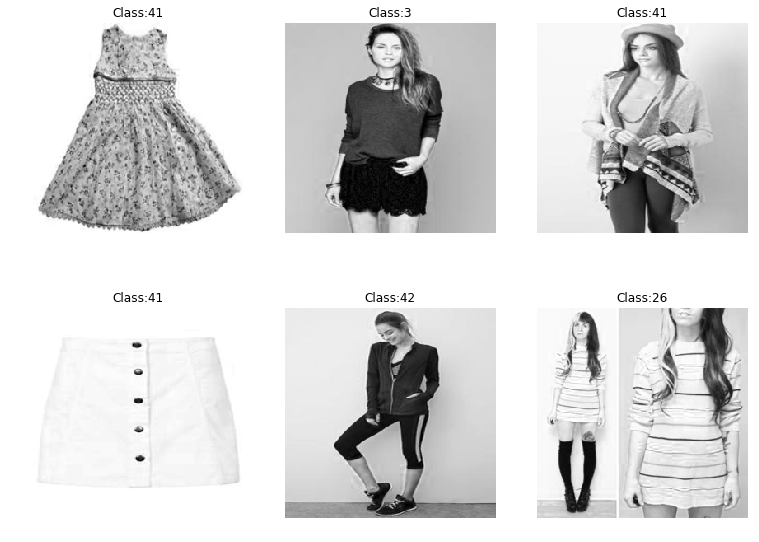

In [72]:
from matplotlib import pyplot as plt
from random import randint
dataset = train_data()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(256, 256), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

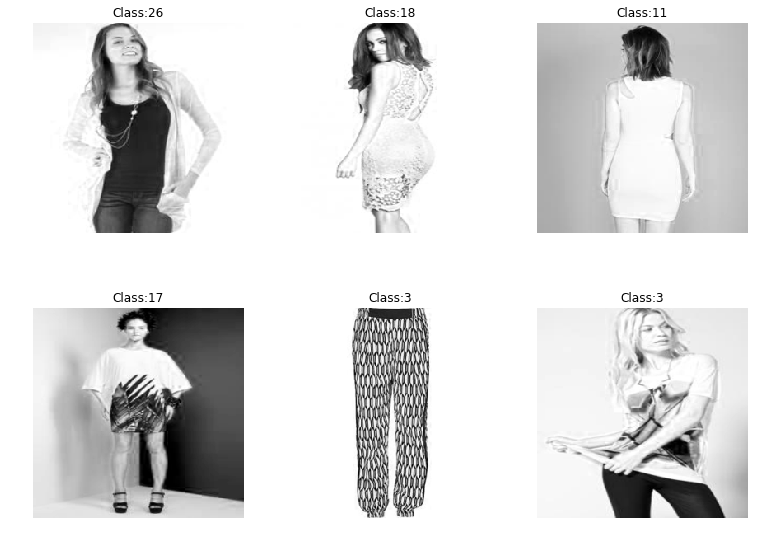

In [73]:
from matplotlib import pyplot as plt
from random import randint
dataset = val_data()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(256, 256), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  

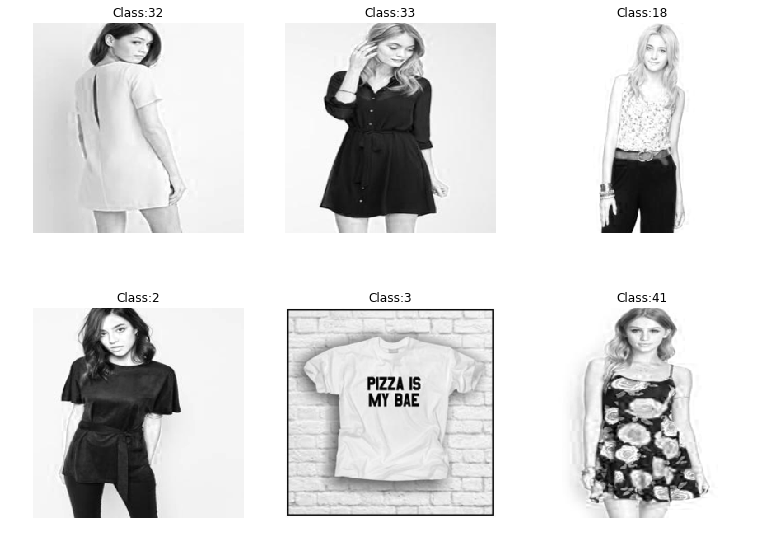

In [74]:
from matplotlib import pyplot as plt
from random import randint
dataset = test_data()

f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
axes = [ax for axs in axes for ax in axs]

for i in range(6):
    index = randint(0, len(dataset))
    image, label = dataset[index]
    axes[i].imshow(image[0].view(256, 256), cmap='gray')
    axes[i].set_title('Class:' + str(label))
    axes[i].axis('off')  